Fig.13

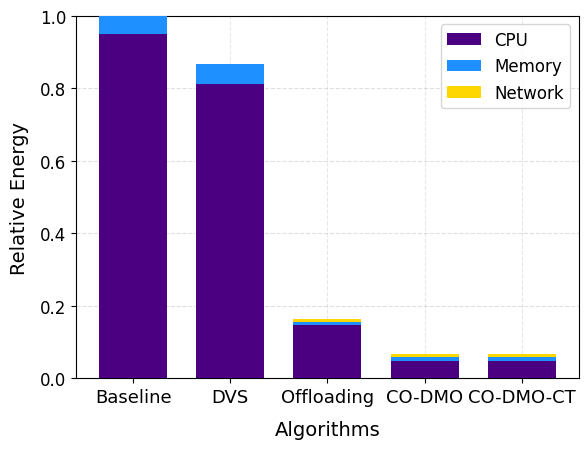

In [117]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
DATA_PATH = Path("/root/new/TOMS/simulators/tmp/network_results.csv")  # 업로드한 파일 경로

# ---- 설정 ----
SCENARIO_NETWORK = 50                            # Network==0 기준
ORDER = ["Baseline", "DVS", "Offloading", "CO-DMO", "CO-DMO-CT"]

# 색상
C_CPU = "#4B0082"   # 보라
C_MEM = "#1E90FF"   # 파랑
C_NET = "#FFD700"   # 노랑

BAR_WIDTH = 0.7  # 막대 굵기(두께) 조절: 값이 작을수록 더 얇아 보임

df = pd.read_csv(DATA_PATH)

# 섹션 표기 통일
section_norm = (
    df["Section"].astype(str).str.strip()
      .str.replace(r"^\s*dvs\s*$", "DVS", regex=True)
      .str.replace(r"^\s*baseline\s*$", "Baseline", regex=True)
      .str.replace(r"^\s*offloading\s*$", "Offloading", regex=True)
      .str.replace(r"^\s*co[-_\s]*dmo[-_\s]*ct\s*$", "CO-DMO-CT", regex=True)
      .str.replace(r"^\s*co[-_\s]*dmo\s*$", "CO-DMO", regex=True)
)
df["Section"] = section_norm

# 시나리오 선택
sub = df[df["Network"] == SCENARIO_NETWORK].copy()
if sub.empty:
    raise ValueError(f"Network == {SCENARIO_NETWORK} 인 행이 없습니다.")

sub = sub[["Section", "Power", "CPU_Power", "Memory_Power", "Network_Power"]]
sub = sub.set_index("Section").reindex(ORDER).fillna(0.0)

# Baseline으로 정규화 → 상대 에너지(0~1)
baseline_total = sub.loc["Baseline", "Power"]
if baseline_total <= 0 or np.isnan(baseline_total):
    raise ValueError("Baseline의 총 Power가 0 또는 결측입니다.")

rel = pd.DataFrame({
    "Algorithm": ORDER,
    "CPU":     sub["CPU_Power"]    / baseline_total,
    "Memory":  sub["Memory_Power"] / baseline_total,
    "Network": sub["Network_Power"]/ baseline_total
})

# ---- Plot (격자 뒤, 세로 격자 추가, 글씨 크게) ----
x = np.arange(len(ORDER))
cpu, mem, net = rel["CPU"].values, rel["Memory"].values, rel["Network"].values

fig, ax = plt.subplots(figsize=(6, 4.6))

# bars를 격자 위로 보이게 zorder 높게
ax.bar(x,  cpu, width=BAR_WIDTH, label="CPU", color=C_CPU, zorder=3)
ax.bar(x,  mem, width=BAR_WIDTH, bottom=cpu, label="Memory", color=C_MEM, zorder=3)
ax.bar(x,  net, width=BAR_WIDTH, bottom=cpu+mem, label="Network", color=C_NET, zorder=3)

# tick 위치(막대 중앙)와 라벨 설정 + 글씨 크기
ax.set_xticks(x)
ax.set_xticklabels(ORDER, fontsize=13)

ax.set_ylim(0, 1.0)
ax.set_ylabel("Relative Energy", fontsize=14,  labelpad=8)
ax.set_xlabel("Algorithms", fontsize=14,  labelpad=10)
ax.tick_params(axis="y", labelsize=12)

# 격자가 막대 뒤에 오도록 + 세로/가로 격자
ax.set_axisbelow(True)
ax.grid(axis="y", linestyle="--", alpha=0.4, zorder=0)
ax.grid(axis="x", linestyle="--", alpha=0.3, zorder=0)

ax.legend(fontsize=12)
fig.tight_layout()
plt.show()


Fig.14

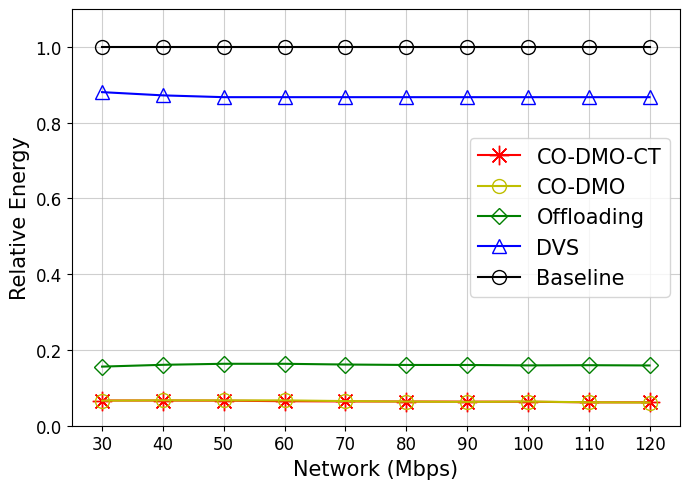

In [118]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path


df = pd.read_csv(DATA_PATH)

# 섹션 표기 정규화 (DVFS → DVS 등)
sec = (df["Section"].astype(str).str.strip()
       .str.replace(r"(?i)^dvfs$", "DVS", regex=True)
       .str.replace(r"(?i)^dvs$", "DVS", regex=True)
       .str.replace(r"(?i)^baseline$", "Baseline", regex=True)
       .str.replace(r"(?i)^offloading$", "Offloading", regex=True)
       .str.replace(r"(?i)^co[\s\-_]*dmo[\s\-_]*ct$", "CO-DMO-CT", regex=True)
       .str.replace(r"(?i)^co[\s\-_]*dmo$", "CO-DMO", regex=True))
df["Section"] = sec

# 동일 Network에서 Baseline 대비 상대 에너지로 정규화
pt = (df.pivot_table(index="Network", columns="Section",
                     values="Power", aggfunc="first")
        .sort_index())
if "Baseline" not in pt.columns:
    raise ValueError("Baseline 데이터가 필요합니다.")
rel = pt.div(pt["Baseline"], axis=0)

# 그릴 구간만 (30~120)
rel_plot = rel.loc[30:120]
x = rel_plot.index.values

# --- 선/마커 스타일: 두 번째 스니펫과 동일 ---
default_lw = plt.rcParams['lines.linewidth']

plt.figure(figsize=(7, 5))

# CO-DMO-CT: 빨강, 별 모양(8,2,0), markersize=14, (채움 유지)
if "CO-DMO-CT" in rel_plot.columns:
    plt.plot(
        x, rel_plot["CO-DMO-CT"].values,
        color='r', label="CO-DMO-CT",
        marker=(8, 2, 0), markersize=14,
        linewidth=default_lw, clip_on=False
    )

# CO-DMO: 노랑, 동그라미, markersize=10, 속 비움
if "CO-DMO" in rel_plot.columns:
    plt.plot(
        x, rel_plot["CO-DMO"].values,
        'yo-', label="CO-DMO",
        markersize=10, markerfacecolor='none',
        linewidth=default_lw, clip_on=False
    )

# Offloading: 초록, 다이아, markersize=8, 속 비움
if "Offloading" in rel_plot.columns:
    plt.plot(
        x, rel_plot["Offloading"].values,
        'gD-', label="Offloading",
        markersize=8, markerfacecolor='none',
        linewidth=default_lw, clip_on=False
    )

# DVS: 파랑, 세모, markersize=10, 속 비움
if "DVS" in rel_plot.columns:
    plt.plot(
        x, rel_plot["DVS"].values,
        'b^-', label="DVS",
        markersize=10, markerfacecolor='none',
        linewidth=default_lw, clip_on=False
    )

# Baseline: 검정, 동그라미, markersize=10, 속 비움
if "Baseline" in rel_plot.columns:
    plt.plot(
        x, rel_plot["Baseline"].values,
        'ko-', label="Baseline",
        markersize=10, markerfacecolor='none',
        linewidth=default_lw, clip_on=False
    )

# 축/격자 설정 (이전 코드와 동일)
plt.xlabel("Network (Mbps)", fontsize=15)
plt.ylabel("Relative Energy", fontsize=15)
plt.xlim(25, 125)
plt.xticks(np.arange(30, 121, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True, linestyle="-", alpha=0.6)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()


Fig.15

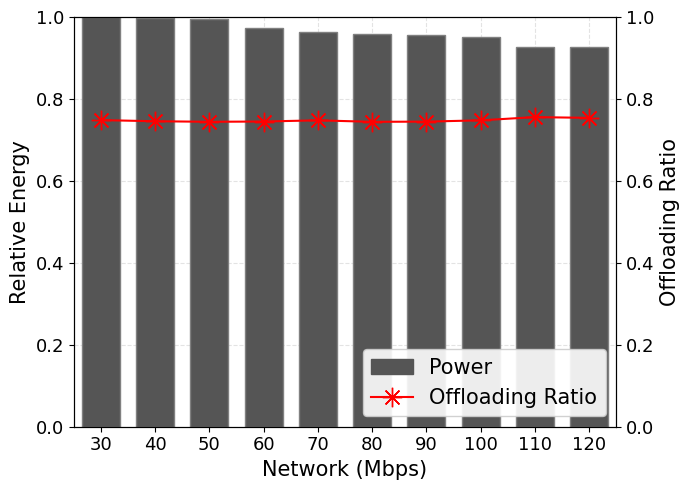

In [122]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pathlib import Path

# Section 이름 통일
df["Section"] = (df["Section"].astype(str).str.strip()
                 .str.replace(r"(?i)^baseline$", "Baseline", regex=True)
                 .str.replace(r"(?i)^co[\s\-_]*dmo[\s\-_]*ct$", "CO-DMO-CT", regex=True))

# CO-DMO-CT / Baseline 추출 및 Network 정렬
co   = df[df["Section"] == "CO-DMO-CT"].set_index("Network")
base = df[df["Section"] == "Baseline"].set_index("Network")
nets = sorted(set(co.index) & set(base.index))
co, base = co.loc[nets].sort_index(), base.loc[nets].sort_index()

# Relative Energy 계산 (첫 Network 값으로 정규화)
rel_series = co["Power"] / base["Power"]
scale = rel_series.loc[min(nets)]
if scale == 0 or np.isnan(scale):
    raise ValueError(f"Network=={min(nets)}에서의 Relative Energy가 0 또는 결측입니다.")
rel_energy = (rel_series / scale).values

# Offloading Ratio 값 정리
off_ratio = pd.to_numeric(co["Offloading_Ratio"], errors="coerce").fillna(0).values
x = np.array(nets)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

# Bars (Relative Energy)
ax.bar(x, rel_energy, width=7.0, color="#555555", edgecolor="gray")
ax.set_ylabel("Relative Energy", fontsize=15)
ymax = max(1.0, rel_energy.max())
ax.set_ylim(0, ymax * 1.0)

# X-axis formatting (유연 설정)
ax.set_xlabel("Network (Mbps)", fontsize=15)
ax.set_xlim(min(x)-5, max(x)+5)
ax.set_xticks(nets)
ax.grid(True, axis="both", linestyle="--", alpha=0.35)
ax.tick_params(axis="both", labelsize=13)
ax.set_axisbelow(True)

# Offloading Ratio (Right Y-axis)
default_lw = plt.rcParams['lines.linewidth']
ax2 = ax.twinx()
(line,) = ax2.plot(
    x, off_ratio,
    color='r', label="Offloading Ratio",
    marker=(8, 2, 0), markersize=14,
    linewidth=default_lw, clip_on=False
)
ax2.set_ylabel("Offloading Ratio", fontsize=15)
ax2.set_ylim(0.0, 1.0)
ax2.tick_params(axis="both", labelsize=13)
ax2.set_axisbelow(True)

# Legend
handles = [Patch(facecolor="#555555", edgecolor="#555555", label="Power"), line]
ax.legend(handles=handles, loc="lower right", framealpha=0.9, fontsize=15)

plt.tight_layout()
plt.show()


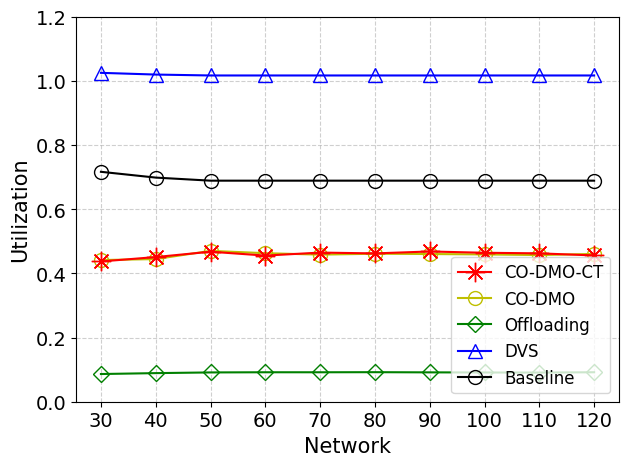

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 공백(스페이스/탭) 구분 파일 읽기
#df = pd.read_csv(file_path, sep=r",", engine="python")
#print(df)


networks = sorted(df["Network"].unique())

# 섹션 이름: 파일은 'DVS'를 사용
methods = ["Baseline", "DVS", "Offloading", "CO-DMO", "CO-DMO-CT"]
legend_labels = {
    "Baseline": "Baseline",
    "DVS": "DVS",
    "Offloading": "Offloading",
    "CO-DMO": "CO-DMO",
    "CO-DMO-CT": "CO-DMO-CT",
}

# 스타일 (에너지 그래프와 동일)
colors = {
    "Baseline": "k",
    "DVS": "b",
    "Offloading": "g",
    "CO-DMO": "y",
    "CO-DMO-CT": "r",
}
markers = {
    "Baseline": "o",
    "DVS": "^",
    "Offloading": "D",
    "CO-DMO": "o",
    "CO-DMO-CT": (8, 2, 0),   # 8-point star-like marker
}
marker_sizes = {
    "Baseline": 10,
    "DVS": 10,
    "Offloading": 8,
    "CO-DMO": 10,
    "CO-DMO-CT": 14,
}

plt.figure(figsize=(7, 5))

for method in methods:
    df_m = df[df["Section"] == method]
    util = (
        df_m.groupby("Network")["Util"]
        .mean()
        .reindex(networks, fill_value=0.0)
        .astype(float)
    )
    x = np.array(networks, dtype=float)

    if method == "CO-DMO-CT":
        plt.plot(
            x, util.values,
            marker=markers[method], color=colors[method],
            label=legend_labels[method],
            markersize=marker_sizes[method], clip_on=False
        )
    elif method == "CO-DMO":
        plt.plot(
            x, util.values,
            "yo-", label=legend_labels[method],
            markersize=marker_sizes[method], markerfacecolor="none",
            clip_on=False
        )
    elif method == "Offloading":
        plt.plot(
            x, util.values,
            "gD-", label=legend_labels[method],
            markersize=marker_sizes[method], markerfacecolor="none",
            clip_on=False
        )
    elif method == "DVS":
        plt.plot(
            x, util.values,
            "b^-", label=legend_labels[method],
            markersize=marker_sizes[method], markerfacecolor="none",
            clip_on=False
        )
    elif method == "Baseline":
        plt.plot(
            x, util.values,
            "ko-", label=legend_labels[method],
            markersize=marker_sizes[method], markerfacecolor="none",
            clip_on=False
        )

plt.xlabel("Network", fontsize=15)
plt.ylabel("Utilization", fontsize=15)
plt.xticks(networks, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 1.2)
plt.grid(True, linestyle="--", alpha=0.6)


# legend 역순
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc="lower right", fontsize=12)

plt.show()
